## RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

### Load the data

In [54]:
from scripts.notebooks.nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# find the last commit hash per repository per year per month
df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year', 'month'], keep='last')
# keep only rows on March (3), June (6), September (9), December (12)
# df_last_hash = df_last_hash[df_last_hash['month'].isin([3, 6, 9, 12])]
df_last_hash = df_last_hash[['repo_url', 'year', 'month', 'commit_hash', 'date']]


# df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year'], keep='last')
# df_last_hash = df_last_hash[['repo_url', 'year', 'commit_hash', 'date']] 
# filter df such that if  only keeps the rows in df if the commit hash is the last commit hash in the repository URL
df = df.merge(df_last_hash, on=['repo_url', 'year','month','date', 'commit_hash'], how='inner')
df['date'].min(), df['date'].max()
df



,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,is_in_commit,change_status,elapsed_days,year,month
0,rinna/japanese-gpt-neox-small,f33d44540298e143079f34c35b21eebe4f3dce89,model.safetensors,safetensors,Adding `safetensors` variant of this model (#2...,Tianyu Zhao,2023-08-04 06:46:32,True,+,315,2023,8
1,rinna/japanese-gpt-neox-small,f33d44540298e143079f34c35b21eebe4f3dce89,pytorch_model.bin,torch.save,Adding `safetensors` variant of this model (#2...,Tianyu Zhao,2023-08-04 06:46:32,False,NaN,315,2023,8
2,rinna/japanese-gpt-neox-small,f33d44540298e143079f34c35b21eebe4f3dce89,spiece.model,ONNX,Adding `safetensors` variant of this model (#2...,Tianyu Zhao,2023-08-04 06:46:32,False,NaN,315,2023,8
3,rinna/japanese-gpt-neox-small,d93a6e4cfd29b7a4cccc068c24f4afab9c218c45,pytorch_model.bin,torch.save,* 2023/03/20 Update the model weight and confi...,Tianyu Zhao,2023-03-20 04:00:35,True,*,178,2023,3
4,rinna/japanese-gpt-neox-small,d93a6e4cfd29b7a4cccc068c24f4afab9c218c45,spiece.model,ONNX,* 2023/03/20 Update the model weight and confi...,Tianyu Zhao,2023-03-20 04:00:35,False,NaN,178,2023,3
...,...,...,...,...,...,...,...,...,...,...,...,...
13603,albert/albert-base-v1,7b2207b0995b9618ed866befd087bee3673f022d,with-prefix-tf_model.h5,h5/hdf5,Update tf_model.h5,system,2020-06-22 11:29:35,False,NaN,-823,2020,6
13604,albert/albert-base-v1,88a9e47f102a579a457fe04451612a6689d20fee,pytorch_model.bin,torch.save,Update spiece.model,system,2020-03-23 13:11:49,False,NaN,-914,2020,3
13605,albert/albert-base-v1,88a9e47f102a579a457fe04451612a6689d20fee,spiece.model,ONNX,Update spiece.model,system,2020-03-23 13:11:49,True,+,-914,2020,3
13606,albert/albert-base-v1,88a9e47f102a579a457fe04451612a6689d20fee,with-prefix-tf_model.h5,h5/hdf5,Update spiece.model,system,2020-03-23 13:11:49,False,NaN,-914,2020,3


### Visualization of serialization format distribution over the years

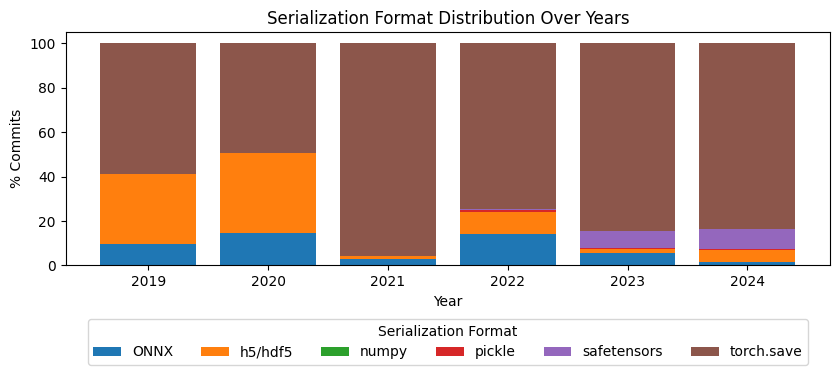

In [51]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt
import numpy as np
# Sample data
df = df[df['serialization_format'] != 'undetermined']
# Compute a slice of the DataFrame with the relevant columns
df_by_date = df[['year', 'serialization_format']]


# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format], 
           bottom=cumulative_values, label=serialization_format)
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Distribution Over Years')
# ax.legend(title='Serialization Format')
# Move the legend outside of the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])


# save as pdf
plt.savefig(RESULTS_DIR/'RQ2ResultsStacked.pdf', format='pdf', bbox_inches='tight')
plt.show()


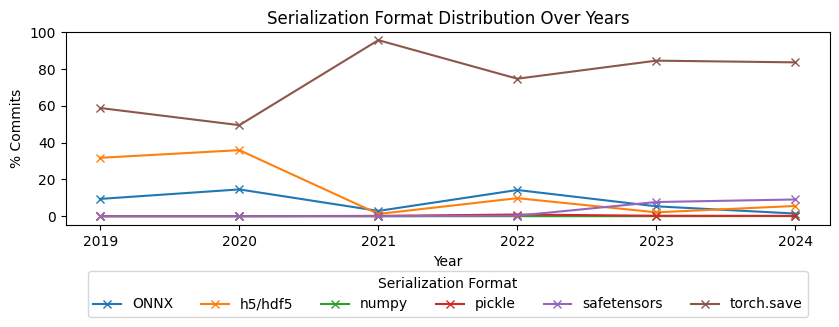

In [52]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt


# Group by year and serialization format, then count occurrences
grouped = df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 4)) 
# make y-axis range from 0 to 100
ax.set_ylim(-5, 100)

# Plot lines for each serialization format
for serialization_format in grouped_percentage.columns:
    ax.plot(grouped_percentage.index, grouped_percentage[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Distribution Over Years')
# Move the legend outside  the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 0.85, 1])  # Adjust the rectangle to fit the legend

# save as pdf
plt.savefig(RESULTS_DIR / 'RQ2ResultsDistribution.pdf', format='pdf', bbox_inches='tight')

plt.show()

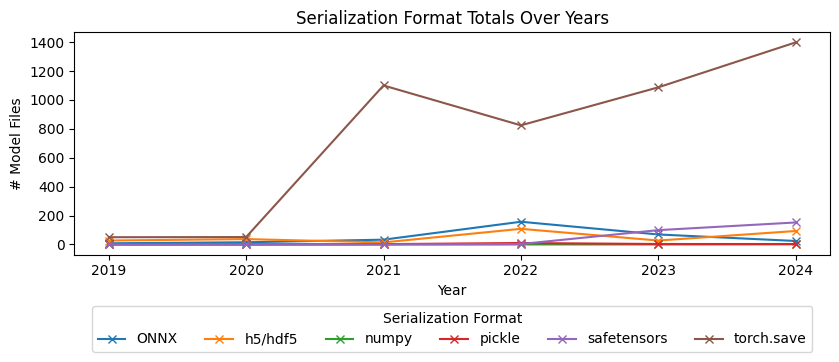

In [53]:
import matplotlib.pyplot as plt


# Filter out rows with 'undetermined' serialization format
filtered_df = df[df['serialization_format'] != 'undetermined']
# Group by year and serialization format, then count occurrences
grouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Set the size of the figure (width, height)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust width and height as needed

# Plot the line chart with counts
for serialization_format in grouped_counts.columns:
    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('# Model Files')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Totals Over Years')

# Move the legend outside of the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.3, 0.85, 1])

plt.show()
